In [1]:
import sys

sys.path.append('../model_generator')
sys.path.append('../patient_sample_generator')
sys.path.append('../ebm')
sys.path.append('../old_model_generator')
sys.path.append('../ebm')

from model_generator.model_factory import ModelFactory
from patient_sample_generator.sample_generator import SampleGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, spearmanr, kendalltau

#from ..model_generator.model_factory import ModelFactory
from old_model_generator.canonical_generator import CanonicalGenerator
from old_model_generator.sample_generator import SampleGenerator

from ebm.probability import log_distributions, fit_distributions
from ebm.mcmc import greedy_ascent, mcmc
from ebm.likelihood import EventProbabilities

In [2]:
def run_ebm(X, y, prior = None, random_state = 1):
    
    log_p_e, log_p_not_e = log_distributions(X, y, point_proba=False)
    
    rng = np.random.RandomState(random_state)
    ideal_order = np.arange(X.shape[1])
    # ditching np.shuffle due to lack of ability to assign randomized starting-order to variable
    starting_order = rng.choice(ideal_order, len(ideal_order), replace=False)
    starting_order_copy = starting_order.copy()
     
    order, loglike, update_iters = greedy_ascent(log_p_e, log_p_not_e, 
                                                n_iter=10_000, order = starting_order,
                                                prior=prior,
                                                random_state=random_state)
    
    greedy_loglike = loglike
    greedy_order = order.copy()
    orders, loglike, update_iters, probas = mcmc(log_p_e, log_p_not_e,
                                                 order=order, n_iter=500_000,
                                                 prior = prior,
                                                 random_state=random_state)
    
    if len(orders) != 0:
        best_order_idx = np.argmax(loglike)
        best_order = orders[best_order_idx]
        best_order = best_order.copy()
    if len(orders) == 0:
        print("Warning: MCMC did not accept new orders, returning greedy ascent result.")
        best_order = order
    
    ## statistical calculations
    
    num_iters = len(orders)
    
    starting_spearmanr, _ = spearmanr(ideal_order, starting_order_copy)
    greedy_spearmanr, _ = spearmanr(ideal_order, greedy_order)
    best_spearmanr, _ = spearmanr(ideal_order, best_order)

    starting_kendalltau, _ = kendalltau(ideal_order, starting_order_copy)
    greedy_kendalltau, _ = kendalltau(ideal_order, greedy_order)
    best_kendalltau, _ = kendalltau(ideal_order, best_order)
    
    ## results dict
    
    results = {
        'starting_order': starting_order_copy,
        'greedy_order': greedy_order,
        'best_order': best_order,
        'starting_spearmanr': starting_spearmanr,
        'greedy_spearmanr': greedy_spearmanr,
        'best_spearmanr': best_spearmanr,        
        'starting_kendalltau': starting_kendalltau,
        'greedy_kendalltau': greedy_kendalltau,
        'best_kendalltau': best_kendalltau,
        'num_iters': num_iters
    }
    
    return results

def run_multiple_ebm(X, y, prior = None, n_trials = 10, csv_filename = 'name.csv'):
    results_list = []

    for trial in range(n_trials):
        result = run_ebm(X, y, prior, random_state=trial)
        results_list.append({
            'run': trial,
            'starting_order': result['starting_order'].tolist(),
            'greedy_order': result['greedy_order'].tolist(),
            'best_order': result['best_order'].tolist(),
            'starting_spearmanr': result['starting_spearmanr'],
            'greedy_spearmanr': result['greedy_spearmanr'],
            'best_spearmanr': result['best_spearmanr'],
            'starting_kendalltau': result['starting_kendalltau'],
            'greedy_kendalltau': result['greedy_kendalltau'],
            'best_kendalltau': result['best_kendalltau']
        })
    
    df = pd.DataFrame(results_list)
    df.to_csv(csv_filename, index=False)
    return df

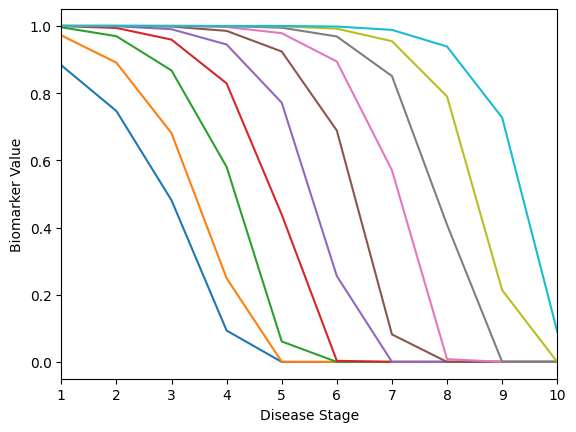

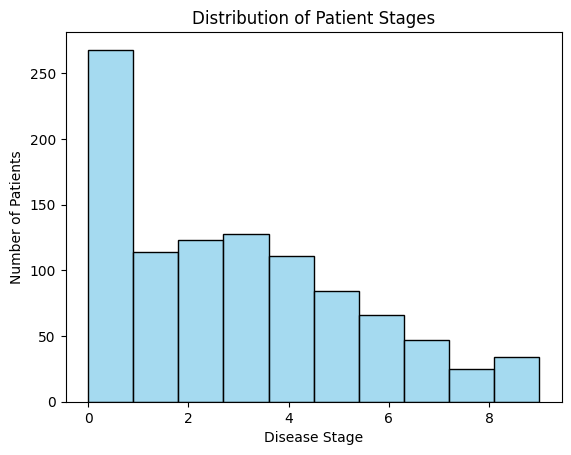

100%|██████████| 500000/500000 [02:24<00:00, 3462.34it/s]


100%|██████████| 500000/500000 [02:20<00:00, 3562.01it/s]


100%|██████████| 500000/500000 [02:33<00:00, 3253.47it/s]


100%|██████████| 500000/500000 [02:32<00:00, 3271.00it/s]


100%|██████████| 500000/500000 [02:32<00:00, 3285.96it/s]


100%|██████████| 500000/500000 [02:21<00:00, 3536.20it/s]


100%|██████████| 500000/500000 [02:21<00:00, 3539.47it/s]


100%|██████████| 500000/500000 [02:23<00:00, 3485.88it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3439.90it/s]


100%|██████████| 500000/500000 [02:24<00:00, 3453.65it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3429.26it/s]


100%|██████████| 500000/500000 [02:25<00:00, 3432.49it/s]


100%|██████████| 500000/500000 [02:36<00:00, 3194.04it/s]


100%|██████████| 500000/500000 [02:36<00:00, 3189.11it/s]


100%|██████████| 500000/500000 [02:32<00:00, 3273.76it/s]


100%|██████████| 500000/500000 [02:41<00:00, 3094.63it/s]


100%|██████████| 500000/500000 [02:42<00:00, 3070.34it/s]


100%|██████████| 500000/500000 [02:42<00:00, 3075.82it/s]


100%|██████████| 500000/500000 [02:42<00:00, 3077.51it/s]


100%|██████████| 500000/500000 [02:35<00:00, 3215.66it/s]


100%|██████████| 500000/500000 [02:27<00:00, 3382.84it/s]


100%|██████████| 500000/500000 [02:28<00:00, 3356.95it/s]


100%|██████████| 500000/500000 [02:27<00:00, 3382.12it/s]


100%|██████████| 500000/500000 [02:32<00:00, 3283.13it/s]


100%|██████████| 500000/500000 [02:40<00:00, 3121.03it/s]


100%|██████████| 500000/500000 [02:40<00:00, 3118.41it/s]


100%|██████████| 500000/500000 [02:29<00:00, 3334.19it/s]


100%|██████████| 500000/500000 [02:27<00:00, 3385.80it/s]


100%|██████████| 500000/500000 [02:29<00:00, 3339.19it/s]


100%|██████████| 500000/500000 [02:28<00:00, 3374.15it/s]


100%|██████████| 500000/500000 [02:29<00:00, 3342.27it/s]


100%|██████████| 500000/500000 [02:28<00:00, 3362.54it/s]


100%|██████████| 500000/500000 [02:28<00:00, 3357.25it/s]


100%|██████████| 500000/500000 [02:35<00:00, 3213.22it/s]


100%|██████████| 500000/500000 [02:40<00:00, 3106.46it/s]


100%|██████████| 500000/500000 [02:41<00:00, 3091.06it/s]


100%|██████████| 500000/500000 [02:28<00:00, 3359.00it/s]


100%|██████████| 500000/500000 [02:26<00:00, 3405.06it/s]


100%|██████████| 500000/500000 [02:26<00:00, 3418.55it/s]


100%|██████████| 500000/500000 [02:28<00:00, 3371.34it/s]

In [3]:
params = {
    'n_stages': 10,
    'coeff': 0.55e-1, 
    'start_time': 0,
    'end_time': 100,
    'steps': 100,
    'convergence_threshold': 1e-4
}

model = ModelFactory.create_model('transition', **params)
model.fit()
prior = model.get_connectivity_matrix()
model.plot()
stage_values = model.transform(X=None) 

sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=1000,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

sample.plot_stage_histogram()


X = sample.get_X()
y = sample.get_y()

#run_multiple_ebm(X=X, y=y, csv_filename="transition_results.csv");

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"transition_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"transition_results_prior_n{sample.n_patients}.csv");

In [4]:
params = {
    'n_stages': 10,
    'coeff': 0.55e-1, 
    'start_time': 0,
    'end_time': 100,
    'steps': 100,
    'convergence_threshold': 1e-4
}

model = ModelFactory.create_model('transition', **params)
model.fit()
prior = model.get_connectivity_matrix()
stage_values = model.transform(X=None) 
sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=500,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

X = sample.get_X()
y = sample.get_y()

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"transition_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"transition_results_prior_n{sample.n_patients}.csv");

100%|██████████| 500000/500000 [01:22<00:00, 6038.11it/s]


100%|██████████| 500000/500000 [01:24<00:00, 5947.67it/s]


100%|██████████| 500000/500000 [01:23<00:00, 5982.52it/s]


100%|██████████| 500000/500000 [01:24<00:00, 5884.72it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5773.51it/s]


100%|██████████| 500000/500000 [01:27<00:00, 5694.41it/s]


100%|██████████| 500000/500000 [01:32<00:00, 5382.38it/s]


100%|██████████| 500000/500000 [01:32<00:00, 5388.28it/s]


100%|██████████| 500000/500000 [01:33<00:00, 5333.21it/s]


100%|██████████| 500000/500000 [01:32<00:00, 5386.49it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5783.64it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5792.32it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5786.56it/s]


100%|██████████| 500000/500000 [01:25<00:00, 5816.80it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5779.60it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5810.13it/s]


100%|██████████| 500000/500000 [01:26<00:00, 5809.41it/s]


100%|██████████| 500000/500000 [01:25<00:00, 5819.53it/s]


100%|██████████| 500000/500000 [01:25<00:00, 5819.37it/s]


100%|██████████| 500000/500000 [01:25<00:00, 5817.85it/s]


100%|██████████| 500000/500000 [01:30<00:00, 5496.55it/s]


100%|██████████| 500000/500000 [01:29<00:00, 5608.30it/s]


100%|██████████| 500000/500000 [01:31<00:00, 5470.71it/s]


100%|██████████| 500000/500000 [01:36<00:00, 5185.07it/s]


100%|██████████| 500000/500000 [01:35<00:00, 5209.88it/s]


100%|██████████| 500000/500000 [01:37<00:00, 5130.06it/s]


100%|██████████| 500000/500000 [01:36<00:00, 5172.44it/s]


100%|██████████| 500000/500000 [01:29<00:00, 5581.81it/s]


100%|██████████| 500000/500000 [01:29<00:00, 5613.61it/s]


100%|██████████| 500000/500000 [01:31<00:00, 5472.69it/s]


100%|██████████| 500000/500000 [01:31<00:00, 5482.95it/s]


100%|██████████| 500000/500000 [01:30<00:00, 5517.84it/s]


100%|██████████| 500000/500000 [01:31<00:00, 5463.67it/s]


100%|██████████| 500000/500000 [01:30<00:00, 5546.40it/s]


100%|██████████| 500000/500000 [01:28<00:00, 5632.75it/s]


100%|██████████| 500000/500000 [01:30<00:00, 5541.32it/s]


100%|██████████| 500000/500000 [01:29<00:00, 5604.65it/s]


100%|██████████| 500000/500000 [01:28<00:00, 5652.41it/s]


100%|██████████| 500000/500000 [01:30<00:00, 5504.07it/s]


100%|██████████| 500000/500000 [01:36<00:00, 5189.78it/s]

In [5]:
params = {
    'n_stages': 10,
    'coeff': 0.55e-1, 
    'start_time': 0,
    'end_time': 100,
    'steps': 100,
    'convergence_threshold': 1e-4
}

model = ModelFactory.create_model('transition', **params)
model.fit()
prior = model.get_connectivity_matrix()
stage_values = model.transform(X=None) 
sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=200,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

X = sample.get_X()
y = sample.get_y()

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"transition_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"transition_results_prior_n{sample.n_patients}.csv");

100%|██████████| 500000/500000 [00:52<00:00, 9560.90it/s] 


100%|██████████| 500000/500000 [00:51<00:00, 9672.72it/s] 


100%|██████████| 500000/500000 [00:51<00:00, 9728.57it/s] 


100%|██████████| 500000/500000 [00:52<00:00, 9562.68it/s] 


100%|██████████| 500000/500000 [00:52<00:00, 9614.90it/s] 


100%|██████████| 500000/500000 [00:51<00:00, 9774.89it/s] 


100%|██████████| 500000/500000 [00:52<00:00, 9571.03it/s] 


100%|██████████| 500000/500000 [00:51<00:00, 9750.36it/s] 


100%|██████████| 500000/500000 [00:55<00:00, 9053.97it/s]


100%|██████████| 500000/500000 [00:55<00:00, 8946.56it/s]


100%|██████████| 500000/500000 [00:55<00:00, 8990.81it/s]


100%|██████████| 500000/500000 [00:56<00:00, 8875.75it/s]


100%|██████████| 500000/500000 [00:55<00:00, 8979.58it/s]


100%|██████████| 500000/500000 [00:54<00:00, 9114.91it/s]


100%|██████████| 500000/500000 [00:55<00:00, 8947.61it/s]


100%|██████████| 500000/500000 [00:52<00:00, 9571.60it/s] 


100%|██████████| 500000/500000 [00:51<00:00, 9650.69it/s] 


100%|██████████| 500000/500000 [00:51<00:00, 9751.55it/s] 


100%|██████████| 500000/500000 [00:51<00:00, 9766.80it/s] 


100%|██████████| 500000/500000 [00:52<00:00, 9572.82it/s] 


In [6]:
params = {
    'n_stages': 10,
    'coeff': 0.55e-1, 
    'start_time': 0,
    'end_time': 100,
    'steps': 100,
    'convergence_threshold': 1e-4
}

model = ModelFactory.create_model('transition', **params)
model.fit()
prior = model.get_connectivity_matrix()
stage_values = model.transform(X=None) 
sample = SampleGenerator(stage_values=stage_values, 
                         n_patients=100,
                         distribution=norm,
                         dist_params = {'loc':2.5, 'scale':3.5, 'random_state':10},
                         add_noise=True,
                         noise_std=0.1,
                         random_state=2)

X = sample.get_X()
y = sample.get_y()

prior = model.get_connectivity_matrix()
run_multiple_ebm(X=X, y=y, n_trials=20, prior=None, csv_filename=f"transition_results_n{sample.n_patients}.csv");
run_multiple_ebm(X=X, y=y, n_trials=20, prior=prior, csv_filename=f"transition_results_prior_n{sample.n_patients}.csv");

100%|██████████| 500000/500000 [00:37<00:00, 13299.19it/s]


100%|██████████| 500000/500000 [00:37<00:00, 13448.00it/s]


100%|██████████| 500000/500000 [00:38<00:00, 13076.70it/s]


100%|██████████| 500000/500000 [00:37<00:00, 13380.84it/s]


100%|██████████| 500000/500000 [00:37<00:00, 13249.66it/s]


100%|██████████| 500000/500000 [00:40<00:00, 12410.00it/s]


100%|██████████| 500000/500000 [00:40<00:00, 12349.88it/s]


100%|██████████| 500000/500000 [00:39<00:00, 12514.36it/s]


100%|██████████| 500000/500000 [00:40<00:00, 12476.98it/s]


100%|██████████| 500000/500000 [00:40<00:00, 12227.02it/s]


100%|██████████| 500000/500000 [00:40<00:00, 12297.88it/s]


100%|██████████| 500000/500000 [00:40<00:00, 12337.34it/s]


100%|██████████| 500000/500000 [00:40<00:00, 12309.66it/s]


100%|██████████| 500000/500000 [00:40<00:00, 12344.10it/s]


100%|██████████| 500000/500000 [00:40<00:00, 12477.28it/s]


100%|██████████| 500000/500000 [00:37<00:00, 13461.62it/s]


100%|██████████| 500000/500000 [00:38<00:00, 13067.98it/s]


100%|██████████| 500000/500000 [00:37<00:00, 13304.97it/s]


100%|██████████| 500000/500000 [00:37<00:00, 13365.12it/s]


100%|██████████| 500000/500000 [00:37<00:00, 13435.17it/s]